# Gradient descent algorithm for Scenario 2


In this part, we implement an gradient descent algorithm to optimization the objective loss function in Scenario 2:


$$\min F := \min \frac{1}{2(n-i)} \sum_{i=1000}^n (fbpredic(i) + a*tby(i) +b*ffr(i) + c*fta(i) - asp(i))^2$$

Gradient descent: 

$$ \beta_k = \beta_{k-1} + \delta* \nabla F, $$
where $\delta$ control how far does each iteration go.


### Detailed plan

First, split the data as train and test with 80% and 20% respectively. For the training part, we need prophet() predicted price, there are a couple of issues. One is prophet() can not predict too far in the future. The other is we can not call prophet() too many times, this takes a lot of time. So we will use a sliding window strategy:

1, Split the train data as train_1 and train_2, where train_1 is used as a sliding window to fit prophet(), and give predictions in train_2. Train_2 is used train the model we proposed above.

2, After we got full size (size of train_2) predictions from prophet(), then we use gradient descent to fit the above model, extracting the coefficients of features to make predicution in the testing data.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
df= pd.read_csv('df7.csv', parse_dates=['Date'])
df = df.rename(columns = {"Date":"ds","Close":"y"}) 
df 
# len(df)

,ds,y,tby,ffr,fta,eps,div,une,vix
0,2005-06-20,1216.10,4.11,3.04,812235.0,84.81,1.76,5.0,148.30
1,2005-06-21,1213.61,4.06,3.04,812235.0,84.81,1.76,5.0,149.00
2,2005-06-22,1213.88,3.95,3.04,811179.0,84.81,1.76,5.0,148.40
3,2005-06-23,1200.73,3.96,3.04,811179.0,84.81,1.76,5.0,150.50
4,2005-06-24,1191.57,3.92,3.04,811179.0,84.81,1.76,5.0,152.00
...,...,...,...,...,...,...,...,...,...
3893,2021-01-25,3855.36,1.05,0.09,7414942.0,95.72,1.58,6.3,25.85
3894,2021-01-26,3849.62,1.05,0.09,7414942.0,95.72,1.58,6.3,25.30
3895,2021-01-27,3750.77,1.04,0.09,7404926.0,95.72,1.58,6.3,33.05
3896,2021-01-28,3787.38,1.07,0.09,7404926.0,95.72,1.58,6.3,30.49


In [4]:
df

,ds,y,tby,ffr,fta,eps,div,une,vix
0,2005-06-20,1216.10,4.11,3.04,812235.0,84.81,1.76,5.0,148.30
1,2005-06-21,1213.61,4.06,3.04,812235.0,84.81,1.76,5.0,149.00
2,2005-06-22,1213.88,3.95,3.04,811179.0,84.81,1.76,5.0,148.40
3,2005-06-23,1200.73,3.96,3.04,811179.0,84.81,1.76,5.0,150.50
4,2005-06-24,1191.57,3.92,3.04,811179.0,84.81,1.76,5.0,152.00
...,...,...,...,...,...,...,...,...,...
3893,2021-01-25,3855.36,1.05,0.09,7414942.0,95.72,1.58,6.3,25.85
3894,2021-01-26,3849.62,1.05,0.09,7414942.0,95.72,1.58,6.3,25.30
3895,2021-01-27,3750.77,1.04,0.09,7404926.0,95.72,1.58,6.3,33.05
3896,2021-01-28,3787.38,1.07,0.09,7404926.0,95.72,1.58,6.3,30.49


In [5]:
from datetime import datetime
p = 0.9
# Train around 90% of dataset 
cutoff = int((p*len(df)//100)*100)
df_train = df[:cutoff].copy()
df_test = df.drop(df_train.index).copy()

print(df_train, df_test)

             ds        y   tby   ffr        fta     eps   div  une     vix
0    2005-06-20  1216.10  4.11  3.04   812235.0   84.81  1.76  5.0  148.30
1    2005-06-21  1213.61  4.06  3.04   812235.0   84.81  1.76  5.0  149.00
2    2005-06-22  1213.88  3.95  3.04   811179.0   84.81  1.76  5.0  148.40
3    2005-06-23  1200.73  3.96  3.04   811179.0   84.81  1.76  5.0  150.50
4    2005-06-24  1191.57  3.92  3.04   811179.0   84.81  1.76  5.0  152.00
...         ...      ...   ...   ...        ...     ...   ...  ...     ...
3495 2019-06-20  2954.18  2.01  2.38  3844016.0  139.61  1.95  3.6   16.10
3496 2019-06-21  2950.46  2.07  2.38  3844016.0  139.61  1.95  3.6   16.55
3497 2019-06-24  2945.35  2.02  2.38  3844016.0  139.61  1.95  3.6   16.29
3498 2019-06-25  2917.38  2.00  2.38  3844016.0  139.61  1.95  3.6   16.69
3499 2019-06-26  2913.78  2.05  2.38  3826817.0  139.61  1.95  3.6   16.55

[3500 rows x 9 columns]              ds        y   tby   ffr        fta     eps   div  une    vix
3

In [11]:
#prophet part 
from fbprophet import Prophet
start = 1000 # 1000 # the number of initial data for training 
pred_size =100 # predicted periods 
num_winds = int((df_train.shape[0]-start)/pred_size) #(4000-1000)/100 =30

pro_pred = []

# use accumulated data to predict the next pred_size data
for i in range(num_winds):
    tmp_train = df_train.iloc[: start+ i*pred_size].copy()
    
    fbp = Prophet(daily_seasonality=True)
    # fit close price using fbprophet model
    fbp.fit(tmp_train[['ds','y']])
    
    # predict pred_size futures and get the forecast price 
    fut = fbp.make_future_dataframe(periods = pred_size,)
    tmp_forecast = fbp.predict(fut) 
    
    # only require the forcast on test data of temporary training data
    pred = tmp_forecast[start+ i*pred_size:].yhat
    pro_pred.append(pred)
    

In [13]:
# pro_pred

[1000    843.297510
 1001    856.104661
 1002    852.543561
 1003    832.175457
 1004    829.387909
            ...    
 1095    646.146808
 1096    643.108344
 1097    639.120987
 1098    634.852825
 1099    646.825493
 Name: yhat, Length: 100, dtype: float64,
 1100    1057.557525
 1101    1056.489569
 1102    1056.256304
 1103    1051.140526
 1104    1050.570645
            ...     
 1195    1075.234791
 1196    1078.011126
 1197    1076.818334
 1198    1075.066651
 1199    1072.741865
 Name: yhat, Length: 100, dtype: float64,
 1200    1189.913008
 1201    1187.962009
 1202    1189.605037
 1203    1194.314116
 1204    1196.617070
            ...     
 1295    1307.510030
 1296    1310.199571
 1297    1312.325702
 1298    1314.743812
 1299    1313.438237
 Name: yhat, Length: 100, dtype: float64,
 1300    1122.891480
 1301    1124.659361
 1302    1126.291339
 1303    1128.206756
 1304    1123.944392
            ...     
 1395    1184.929151
 1396    1187.265246
 1397    1196.099314
 13

In [15]:
flat_pro_pred = [item for l1 in pro_pred for item in l1]
# flat_pro_pred

In [21]:
train_pred_yhat = [np.nan for i in range(start)] + flat_pro_pred


In [27]:
df2 = df_train.copy()
df2['fbsp'] = pd.Series(train_pred_yhat)
df2 = df2.loc[start:].copy()
df2['diff'] = df2['y'].copy() - df2['fbsp'].copy()
df2

,ds,y,tby,ffr,fta,eps,div,une,vix,fbsp,diff
1000,2009-06-19,921.23,3.79,0.21,2072938.0,9.03,2.90,9.5,31.50,843.297510,77.932490
1001,2009-06-22,893.04,3.72,0.21,2072938.0,9.03,2.90,9.5,32.75,856.104661,36.935339
1002,2009-06-23,895.10,3.65,0.21,2072938.0,9.03,2.90,9.5,32.00,852.543561,42.556439
1003,2009-06-24,900.94,3.72,0.21,2025828.0,9.03,2.90,9.5,30.60,832.175457,68.764543
1004,2009-06-25,920.26,3.55,0.21,2025828.0,9.03,2.90,9.5,29.15,829.387909,90.872091
...,...,...,...,...,...,...,...,...,...,...,...
3495,2019-06-20,2954.18,2.01,2.38,3844016.0,139.61,1.95,3.6,16.10,3003.562802,-49.382802
3496,2019-06-21,2950.46,2.07,2.38,3844016.0,139.61,1.95,3.6,16.55,3003.682323,-53.222323
3497,2019-06-24,2945.35,2.02,2.38,3844016.0,139.61,1.95,3.6,16.29,3003.385785,-58.035785
3498,2019-06-25,2917.38,2.00,2.38,3844016.0,139.61,1.95,3.6,16.69,3002.756425,-85.376425


In [28]:
df2.columns

Index(['ds', 'y', 'tby', 'ffr', 'fta', 'eps', 'div', 'une', 'vix', 'fbsp',
       'diff'],
      dtype='object')

In [30]:
ft_df = df2[['diff', 'tby', 'ffr', 'fta', 'eps', 'div', 'une', 'vix']].copy()
ft_df.corr()['diff'].sort_values()

vix    -0.397538
eps    -0.278977
fta    -0.084767
ffr    -0.076702
div     0.015690
une     0.084706
tby     0.175860
diff    1.000000
Name: diff, dtype: float64

In [35]:
del(ft_df['vixf_sq'])

In [62]:
ft_df['vix_sq'] = ft_df['vix']**2
ft_df['sqrt_vix'] = np.sqrt(ft_df['vix'])
ft_df['tby_sq'] = ft_df['tby']**2
ft_df['tby_sqsq'] = ft_df['tby']**4
ft_df['tby_sqrt'] = np.sqrt(ft_df['tby'])
ft_df['eps_sq'] = ft_df['eps']**2
ft_df['eps_sqrt'] = np.sqrt(ft_df['eps'])
ft_df['fta_sq'] = ft_df['fta']**2
ft_df['fta_log'] = np.log(ft_df['fta'])
ft_df['div_log'] = np.log(ft_df['div'])



df['div_une_vix'] = df['div'] * df['une'] * df['vix']

ft_df['une_div'] = ft_df['une'] * ft_df['div']
ft_df['une_div_eps_vix'] = ft_df['une'] * ft_df['div'] * ft_df['eps']*ft_df['vix']

ft_df['une_div_eps_vix_fta'] = ft_df['une'] * ft_df['div'] * ft_df['eps']*ft_df['vix'] * ft_df['fta']
ft_df['une_div_eps_vix_fta_ffr'] = ft_df['une'] * ft_df['div'] * ft_df['eps']*ft_df['vix'] * ft_df['fta']*ft_df['ffr']

ft_df.corr()['diff'].sort_values()

une_div_eps_vix_fta       -0.601919
une_div_eps_vix           -0.443862
sqrt_vix                  -0.397834
vix                       -0.397538
vix_sq                    -0.370680
eps_sqrt                  -0.297865
eps                       -0.278977
une_div_eps               -0.263526
une_div_eps_vix_fta_ffr   -0.256619
eps_sq                    -0.244340
fta_log                   -0.097403
fta                       -0.084767
ffr                       -0.076702
fta_sq                    -0.073779
div_log                   -0.028243
div                       -0.003671
une                        0.084706
une_div                    0.109024
tby_sqrt                   0.170472
tby                        0.175860
tby_sq                     0.183628
tby_sqsq                   0.188662
diff                       1.000000
Name: diff, dtype: float64

In [47]:
ft_df2 = np.log(df2[['diff', 'tby', 'ffr', 'fta', 'eps', 'div', 'une', 'vix']]).copy()
ft_df2.corr()['diff'].sort_values()

une    -0.225626
eps    -0.192782
vix    -0.165096
tby     0.062395
fta     0.086756
div     0.116801
ffr     0.340870
diff    1.000000
Name: diff, dtype: float64

In [16]:
df.columns

Index(['ds', 'y', 'tby', 'ffr', 'fta', 'eps', 'div', 'une', 'vix'], dtype='object')

In [11]:
possible_features = ['tby', 'ffr', 'fta', 'eps', 'div', 'une', 'vix']

In [10]:
ft_df = df_train[start:].copy()
ft_df['fbsp'] = pd.Series(flat_pro_pred) 
ft_df

,ds,y,tby,ffr,fta,eps,div,une,vix,fbsp
2000,2013-06-21,1592.43,2.52,0.09,3470530.0,102.19,2.01,7.5,18.98,NaN
2001,2013-06-24,1573.09,2.57,0.09,3470530.0,102.19,2.01,7.5,20.12,NaN
2002,2013-06-25,1588.03,2.60,0.09,3470530.0,102.19,2.01,7.5,19.42,NaN
2003,2013-06-26,1603.26,2.55,0.09,3478672.0,102.19,2.01,7.5,18.83,NaN
2004,2013-06-27,1613.20,2.49,0.09,3478672.0,102.19,2.01,7.5,18.16,NaN
...,...,...,...,...,...,...,...,...,...,...
3495,2019-06-20,2954.18,2.01,2.38,3844016.0,139.61,1.95,3.6,16.10,NaN
3496,2019-06-21,2950.46,2.07,2.38,3844016.0,139.61,1.95,3.6,16.55,NaN
3497,2019-06-24,2945.35,2.02,2.38,3844016.0,139.61,1.95,3.6,16.29,NaN
3498,2019-06-25,2917.38,2.00,2.38,3844016.0,139.61,1.95,3.6,16.69,NaN


In [12]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False, normalize=True, copy_X = True)
reg.fit(df_train[start:cutoff][possible_features], df_train[start:cutoff]['y'] - flat_pro_pred)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)

In [13]:
coef = []
for i in range(len(possible_features)):
    coef.append(np.round(reg.coef_[i],5))

print(coef)

[32.39174, 91.33889, 0.00017, -4.82482, -303.57682, 62.01948]


In [14]:
# Forecast the Test Data
from fbprophet import Prophet
test_time = int((1-p)* len(df))
fbp = Prophet(daily_seasonality=True)
fbp.fit(df_train[['ds','y']])
fut = fbp.make_future_dataframe(periods = test_time)
forecast = fbp.predict(fut)

pred_test = forecast[cutoff:cutoff+test_time].yhat
pred_test = pred_test.ravel()

In [15]:
len(pred_test)

451

In [16]:
pp_test = pred_test.copy() # predicted price on testing data 
pp_train = flat_pro_pred.copy() # predicted price on training data 
for i in range(len(possible_features)):
    pp_test += coef[i] * df_test[df_test.columns[i+2]][:test_time].ravel()
    pp_train += coef[i] * df_train[df_train.columns[i+2]][start:].ravel()


In [17]:
from sklearn.metrics import mean_squared_error as MSE
# MSE for test data
# Actual close price: df_test[:test_time].y 
# Predicted price by prophet: pred_test
# Predicted price by tuning 
mse1 = MSE(df_test[:test_time].y, pred_test) #
mse2 = MSE(df_test[:test_time].y, pp_test)
print(mse1,mse2)

40990.288919792314 236214.55169778992


In [18]:
# MSE for train data
mse3 = MSE(df_train[start:].y, flat_pro_pred)
mse4 = MSE(df_train[start:].y, pp_train)
print(mse3,mse4)

26135.01416813597 16628.737696789463


In [31]:
len(flat_pro_pred)

3000

In [32]:
pred_yhat = [np.nan for i in range(start)] + flat_pro_pred

2100.7911220663395

In [38]:
d = {'ds': df_train.ds,'yhat':pred_yhat    }
pred_df = pd.DataFrame(data=d )
pred_df

,ds,yhat
0,2003-01-02,NaN
1,2003-01-03,NaN
2,2003-01-06,NaN
3,2003-01-07,NaN
4,2003-01-08,NaN
...,...,...
3995,2018-12-24,2807.111434
3996,2018-12-26,2807.792864
3997,2018-12-27,2808.104845
3998,2018-12-28,2816.669476


In [ ]:
le

In [41]:
pred_df.loc[1000]

ds      2007-01-03 00:00:00
yhat            1447.039729
Name: 1000, dtype: object

In [49]:
date = df_test[:test_time].ds
date

4000   2019-01-02
4001   2019-01-03
4002   2019-01-04
4003   2019-01-07
4004   2019-01-08
          ...    
4446   2020-10-13
4447   2020-10-14
4448   2020-10-15
4449   2020-10-16
4450   2020-10-19
Name: ds, Length: 451, dtype: datetime64[ns]

In [63]:
forecast

In [55]:
# forecast = forecast[cutoff:].replace({'ds': date }, inplace=True)

/Users/yuqingdai/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [58]:
forecast

In [59]:
df_test

,ds,y,tby,ffr,fta,eps,div,une
4000,2019-01-02,2510.03,2.66,2.40,4058378.0,139.58,2.09,4.0
4001,2019-01-03,2447.89,2.56,2.40,4058378.0,139.58,2.09,4.0
4002,2019-01-04,2531.94,2.67,2.40,4058378.0,139.58,2.09,4.0
4003,2019-01-07,2549.69,2.70,2.40,4058378.0,139.58,2.09,4.0
4004,2019-01-08,2574.41,2.73,2.40,4058378.0,139.58,2.09,4.0
...,...,...,...,...,...,...,...,...
4515,2021-01-25,3855.36,1.05,0.09,7414942.0,95.72,1.58,6.3
4516,2021-01-26,3849.62,1.05,0.09,7414942.0,95.72,1.58,6.3
4517,2021-01-27,3750.77,1.04,0.09,7404926.0,95.72,1.58,6.3
4518,2021-01-28,3787.38,1.07,0.09,7404926.0,95.72,1.58,6.3


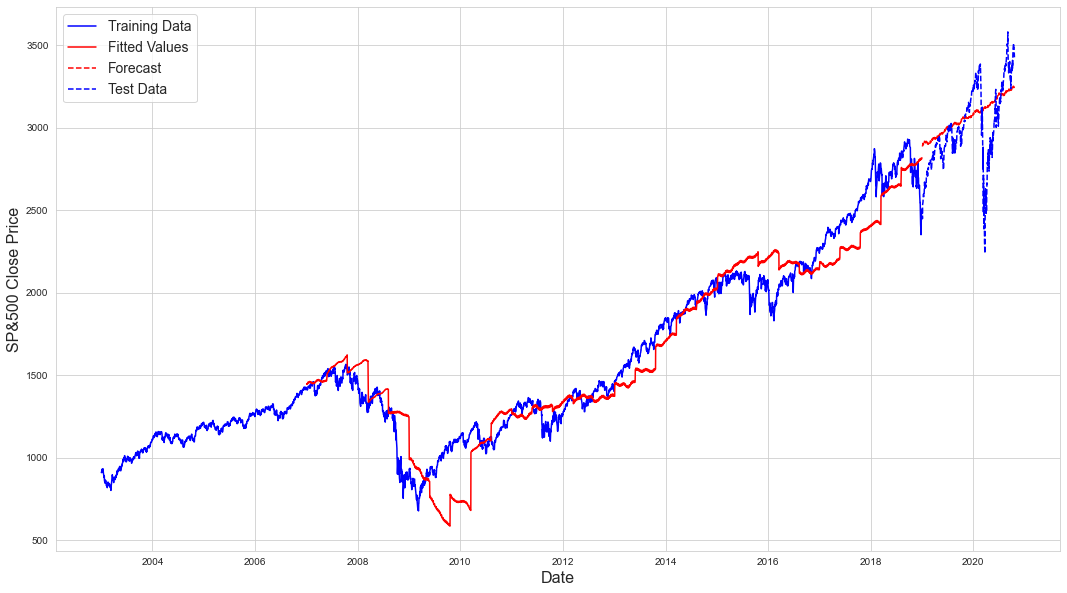

In [43]:
m = len(forecast[cutoff:])
plt.figure(figsize=(18,10))

# plot the training data
plt.plot(df_train.ds,df_train.y,'b',
            label = "Training Data")

# plot the fit
plt.plot(df_train.ds, pred_df.yhat,'r-',
            label = "Fitted Values")

# plot the forecast
plt.plot(df_test[:m].ds, forecast[cutoff:].yhat,'r--',
            label = "Forecast")

plt.plot(df_test[:m].ds,df_test[:m].y,'b--',
            label = "Test Data")

plt.legend(fontsize=14)

plt.xlabel("Date", fontsize=16)
plt.ylabel("SP&500 Close Price", fontsize=16)

plt.show()